### Probabilistic Stream Temperature Forecasting Application Programming Interface (API)
##### 48-Hour temperature predictions for USGS gage 01389005

Temperature of freshwater systems is a well--studied phenomenon with a number of physical, biological, and ecological responses. Advancement in accurate forecasting of real--time stream temperatures is critical to regional water management because it informs policy decisions. For example, the Delaware River Basin Commission (DRBC) regulates freshwater withdraws from reservoirs to maintain a maximum river temperature during summer months to support aquatic wildlife habitat. The ability to estimate temperature is impacted by the complexity of interactions between stream and river networks, ground water, and meteorological conditions. A number of attempts have been made to mechanistically predict temperature with some success, but these methods require persistent measurements and an understanding of the direct relationship between weather and its impacts on stream conditions.  This work presents a machine learning (ML) model based on the spatial configuration of streams and their historical temperature relationships given external factors. Specifically, our approach relies on a novel ML architecture that combines the signal processing power of wavelet analysis, TensorFlow Probability layers, and graph convolution network layers. Via spectral clustering, we extract structural properties of the geographical area being analyzed, and extract correlative relationships between relevant time--varying signals and the area geography. The result is a temperature forecast with hourly resolution tailored to the particular geography in question.  We show that our approach outperforms other state--of--the--art temperature modeling approaches in an area surrounding the Mid-Atlantic hydrologic region. Finally, we discuss the potential to scale this approach to other watersheds.

Paper Submitted:

McDonald, A.W.E., Campagna M., Haag S., Perez L.B. & Shokoufandeh, A. (2021). Graph Convolutions with Wavelets for Probabilistic Stream Temperature Forecasting. AGU Water Resources Research.

In [2]:
from ipyleaflet import Map, basemaps, Polygon, DrawControl, WidgetControl, GeoJSON, MeasureControl, WKTLayer, Popup
from ipywidgets import IntSlider, ColorPicker, jslink, HTML
import sys
import requests
import geojson
import json
import shapely
from shapely.geometry import shape, GeometryCollection
import matplotlib.pyplot as plt
import xmltodict
import pprint
import time
from datetime import datetime

In [3]:
# LOAD IN THE GAGE DATA
with open('usgs_gages.geojson') as json_file:
    features = json.load(json_file)["features"]
with open('usgs_gages.geojson') as json_file:
    gage_lkup = json.load(json_file)

gages = GeometryCollection([shape(feature["geometry"]) for feature in features])

with open('usgs_gages_wtshds.geojson') as json_file:
    features = json.load(json_file)["features"]

gage_watersheds = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])


In [29]:
# PICK THE USGS GAGE OR LOCATION THAT YOU WANT MODELED

gage_labels = {'01382170': [gages[0].coords.xy[0][0], gages[0].coords.xy[1][0]],
         '01382210': [gages[1].coords.xy[0][0], gages[1].coords.xy[1][0]],
         '01382310': [gages[2].coords.xy[0][0], gages[2].coords.xy[1][0]],
         '01382381': [gages[3].coords.xy[0][0], gages[3].coords.xy[1][0]], 
         '01382385': [gages[4].coords.xy[0][0], gages[4].coords.xy[1][0]], 
         '01389005': [gages[5].coords.xy[0][0], gages[5].coords.xy[1][0]]}

# Map centred on target watersheds
map_center = (gage_watersheds[5].centroid.coords[0][1], gage_watersheds[5].centroid.coords[0][0])
displaymap1 = Map(center = map_center, zoom = 9, min_zoom = 1, max_zoom = 20,  scroll_wheel_zoom = True,
    basemap=basemaps.Esri.WorldStreetMap)

# Enable drawing points/polygons/lines
draw_control = DrawControl()
draw_control.point =  {
    "shapeOptions": {
        "color": "#6bc2e5",
        "weight": 1,
        "opacity": 1.0
    }
}
draw_control.polyline =  {
    "shapeOptions": {
        "color": "#6bc2e5",
        "weight": 4,
        "opacity": 1.0
    }
}
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 0.3
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": True
}

watersheds_layer = WKTLayer(
    wkt_string=gage_watersheds.wkt,
    style={
        'opacity': 1, 'dashArray': '2', 'fillOpacity': 0.2, 'weight': 1, 'color': 'blue'
    }
)

gages_layer = WKTLayer(
    wkt_string=gages.wkt,
    label = gage_labels
    
)

# Save the drawn geometry to a geojson
draw_feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

click_feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    # Save the GeoJSON when it's drawn on the map  
    draw_feature_collection['features'].append(geo_json)

def handle_click(**kwargs):
    # Save the last clicked point
    click_feature_collection['features'].append(kwargs['feature'])
    x = kwargs['feature']['geometry']['coordinates'][0]
    y = kwargs['feature']['geometry']['coordinates'][1]
    for label, coords in gage_labels.items():
        if gage_labels[label][0] == x and gage_labels[label][1] == y:
            gage = label
            print('Selected USGS Gage Station {} at ({},{})'.format(gage, y, x), end='\r')

gages_layer.on_click(handle_click)

# Add everything into the map
draw_control.on_draw(handle_draw)
displaymap1.add_control(draw_control)
displaymap1.add_layer(gages_layer)
displaymap1.add_layer(watersheds_layer)

displaymap1


Map(center=[40.98064101320725, -74.36654960990295], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [30]:
# Show the clicked gage
last_geom_idx = len(click_feature_collection['features']) - 1
last_geom = click_feature_collection['features'][last_geom_idx]['geometry']
x = last_geom['coordinates'][0]
y = last_geom['coordinates'][1]
for label, coords in gage_labels.items():
        if gage_labels[label][0] == x and gage_labels[label][1] == y:
            gage = label
print(gage)
last_geom

01389005


{'type': 'Point', 'coordinates': [-74.2691667, 40.89638889000001]}

In [31]:
gage = '01419500'

In [32]:
# GET NWIS DATA for POR of Last 7 Days
nwis_url = 'http://waterservices.usgs.gov/nwis/iv/?sites={}&parameterCd=00010&period=P7D'.format(gage)
#_headers = {'Content-Type': 'application/json'}
_r = requests.post(nwis_url, allow_redirects=True, verify=True)
_r.text


'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><ns1:timeSeriesResponse xsi:schemaLocation="http://www.cuahsi.org/waterML/1.1/ http://waterservices.usgs.gov/WaterML-1.1.xsd" xmlns:ns1="http://www.cuahsi.org/waterML/1.1/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"><ns1:queryInfo xmlns:ns2="http://www.cuahsi.org/waterML/1.1/"><ns2:queryURL>http://waterservices.usgs.gov/nwis/iv/sites=01419500&amp;parameterCd=00010&amp;period=P7D</ns2:queryURL><ns2:criteria><ns2:locationParam>[ALL:01419500]</ns2:locationParam><ns2:variableParam>[00010]</ns2:variableParam></ns2:criteria><ns2:note title="filter:sites">[ALL:01419500]</ns2:note><ns2:note title="filter:timeRange">[mode=PERIOD, period=P7D, modifiedSince=null]</ns2:note><ns2:note title="filter:methodId">methodIds=[ALL]</ns2:note><ns2:note title="requestDT">2021-05-14T18:56:45.063Z</ns2:note><ns2:note title="requestId">20cb6350-b4e6-11eb-a9ba-005056beda50</ns2:note><ns2:note title="disclaimer">Provisional data are subject to rev

In [41]:
null = 'None'
print(json.dumps(xmltodict.parse(_r.text)))
test1 = eval(json.dumps(xmltodict.parse(_r.text)))
wt_ts_raw = test1['ns1:timeSeriesResponse']['ns1:timeSeries']['ns1:values']
wt_ts_raw[0]['ns1:value'][0]

{"ns1:timeSeriesResponse": {"@xsi:schemaLocation": "http://www.cuahsi.org/waterML/1.1/ http://waterservices.usgs.gov/WaterML-1.1.xsd", "@xmlns:ns1": "http://www.cuahsi.org/waterML/1.1/", "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance", "ns1:queryInfo": {"@xmlns:ns2": "http://www.cuahsi.org/waterML/1.1/", "ns2:queryURL": "http://waterservices.usgs.gov/nwis/iv/sites=01419500&parameterCd=00010&period=P7D", "ns2:criteria": {"ns2:locationParam": "[ALL:01419500]", "ns2:variableParam": "[00010]"}, "ns2:note": [{"@title": "filter:sites", "#text": "[ALL:01419500]"}, {"@title": "filter:timeRange", "#text": "[mode=PERIOD, period=P7D, modifiedSince=null]"}, {"@title": "filter:methodId", "#text": "methodIds=[ALL]"}, {"@title": "requestDT", "#text": "2021-05-14T18:56:45.063Z"}, {"@title": "requestId", "#text": "20cb6350-b4e6-11eb-a9ba-005056beda50"}, {"@title": "disclaimer", "#text": "Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more 

KeyError: 0

In [42]:
# FOR GAGES WITH MULTIPLE INTAKES (RIGHT, CENTER, LEFT), WE NEED TO AVERAGE ALL OF THEM TOGETHER
wt_ts = {}
for i in range(0, len(wt_ts_raw)):
    for j in range(0,len(wt_ts_raw[i]['ns1:value']) - 1):
        if str(wt_ts_raw[i]['ns1:value'][j]['@dateTime']) in wt_ts.keys():
            wt_ts[str(wt_ts_raw[i]['ns1:value'][j]['@dateTime'])] += float(wt_ts_raw[i]['ns1:value'][j]['#text'])
        else:
            wt_ts[str(wt_ts_raw[i]['ns1:value'][j]['@dateTime'])] = float(wt_ts_raw[i]['ns1:value'][j]['#text'])

for i in wt_ts:
        wt_ts[i] = float(wt_ts[i]/len(wt_ts_raw))

wt_ts

KeyError: 0

In [34]:
# SET UP TIME VARIABLES FOR WEATHER DATA
now_ep = int(time.time())
now_dt = datetime.now()
seconds_since_midnight = int((now_dt - now_dt.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()) - 3600
day = 60*60*24
week = day * 7
last_week = now_ep - seconds_since_midnight - week

In [35]:
# GET LAST WEEK OF METEOROLOGICAL DATA

'''
Dark Sky is Best for Historical Data, however we cannot get new API keys so we might want to use a different service

API FORMATTING
"https://api.darksky.net/forecast/{}/{},{},{}".format([key], [latitude], [longitude], [time])

Gives daily min, max and hourly temperatures.
- sunrise/sunset
- precipitation intensity, probability, and type
- dewpoint, humidity, pressure, wind speed, visibility
- cloud cover (0-1), uvIndex, ozone
- nearest station
'''

locationt = (y, x)
ds_key = '1c78f26704537fe8484c246658d49fe1'

weather_arr = []
time_curr = last_week
for i in range(0,8):
    urlt = "https://api.darksky.net/forecast/{}/{},{},{}?exclude=currently,minutely,daily,flags,alerts".format(ds_key, locationt[0], locationt[1], time_curr)
    time_curr += day
    response = requests.request("GET", urlt)#, headers=headers)
    dt = eval(response.text)
    weather_arr.append(dt)

weather_arr


[{'latitude': 40.89638889000001,
  'longitude': -74.2691667,
  'timezone': 'America/New_York',
  'hourly': {'summary': 'Partly cloudy throughout the day.',
   'icon': 'partly-cloudy-day',
   'data': [{'time': 1620360000,
     'summary': 'Partly Cloudy',
     'icon': 'partly-cloudy-night',
     'precipIntensity': 0,
     'precipProbability': 0,
     'temperature': 53.21,
     'apparentTemperature': 53.21,
     'dewPoint': 30.33,
     'humidity': 0.41,
     'pressure': 1015.1,
     'windSpeed': 3.09,
     'windGust': 17.15,
     'windBearing': 354,
     'cloudCover': 0.56,
     'uvIndex': 0,
     'visibility': 10,
     'ozone': 367.2},
    {'time': 1620363600,
     'summary': 'Partly Cloudy',
     'icon': 'partly-cloudy-night',
     'precipIntensity': 0,
     'precipProbability': 0,
     'temperature': 51.45,
     'apparentTemperature': 51.45,
     'dewPoint': 30.61,
     'humidity': 0.45,
     'pressure': 1014.8,
     'windSpeed': 3.04,
     'windGust': 12.53,
     'windBearing': 356,
 

In [36]:
# FORMAT THE TEMPERATURE DATA TO VISUALIZE ON THE MAP
at_ts = {}
dt['hourly']['data']

[{'time': 1620964800,
  'summary': 'Clear',
  'icon': 'clear-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 53.18,
  'apparentTemperature': 53.18,
  'dewPoint': 37.05,
  'humidity': 0.54,
  'pressure': 1023.1,
  'windSpeed': 2.03,
  'windGust': 6.15,
  'windBearing': 251,
  'cloudCover': 0.05,
  'uvIndex': 0,
  'visibility': 10,
  'ozone': 369.3},
 {'time': 1620968400,
  'summary': 'Clear',
  'icon': 'clear-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 51.79,
  'apparentTemperature': 51.79,
  'dewPoint': 37.83,
  'humidity': 0.59,
  'pressure': 1023.2,
  'windSpeed': 2.4,
  'windGust': 6.4,
  'windBearing': 289,
  'cloudCover': 0.04,
  'uvIndex': 0,
  'visibility': 10,
  'ozone': 372.6},
 {'time': 1620972000,
  'summary': 'Clear',
  'icon': 'clear-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 49.42,
  'apparentTemperature': 49.42,
  'dewPoint': 36.99,
  'humidity': 0.62,
  'pressure': 1023.1,
  'windS

In [37]:
# FORMAT ONE OF THE VARIABLES FOR VISUALIZATION (i.e. AIR TEMPERATURE)

at_ts = {}
for i in range(0, len(weather_arr)):
    for j in range(0,len(weather_arr[i]['hourly']['data'])):
        time_add = weather_arr[i]['hourly']['data'][j]['time']
        time_add = time.strftime('%Y-%m-%dT%H:%M:%S.000-04:00', time.localtime(time_add))
        temp_c = (weather_arr[i]['hourly']['data'][j]['temperature'] - 32) * (5/9)
        at_ts[time_add] = temp_c
at_ts

{'2021-05-07T00:00:00.000-04:00': 11.783333333333335,
 '2021-05-07T01:00:00.000-04:00': 10.805555555555557,
 '2021-05-07T02:00:00.000-04:00': 9.755555555555556,
 '2021-05-07T03:00:00.000-04:00': 8.7,
 '2021-05-07T04:00:00.000-04:00': 8.405555555555557,
 '2021-05-07T05:00:00.000-04:00': 7.5500000000000025,
 '2021-05-07T06:00:00.000-04:00': 6.883333333333334,
 '2021-05-07T07:00:00.000-04:00': 8.733333333333333,
 '2021-05-07T08:00:00.000-04:00': 11.627777777777778,
 '2021-05-07T09:00:00.000-04:00': 13.511111111111111,
 '2021-05-07T10:00:00.000-04:00': 14.894444444444446,
 '2021-05-07T11:00:00.000-04:00': 16.016666666666666,
 '2021-05-07T12:00:00.000-04:00': 16.916666666666668,
 '2021-05-07T13:00:00.000-04:00': 17.16111111111111,
 '2021-05-07T14:00:00.000-04:00': 18.061111111111114,
 '2021-05-07T15:00:00.000-04:00': 18.166666666666668,
 '2021-05-07T16:00:00.000-04:00': 17.938888888888894,
 '2021-05-07T17:00:00.000-04:00': 16.944444444444446,
 '2021-05-07T18:00:00.000-04:00': 16.02777777777

In [38]:
# GET FORECAST OF METEOROLOGICAL DATA

# For next 168 hours
# urlt = "https://api.darksky.net/forecast/{}/{},{}?extend=hourly?exclude=currently,minutely,daily,alerts,flags".format(ds_key, locationt[0], locationt[1])

# For next 48 hours
url_fc = "https://api.darksky.net/forecast/{}/{},{}?exclude=currently,minutely,daily,alerts,flags".format(ds_key, locationt[0], locationt[1])

response_fc = requests.request("GET", url_fc)

dt_fc = eval(response_fc.text)


In [39]:
# FORMAT THE FORCAST INTO THE HISTORICAL ARRAY
at_ts_fc = {}
for i in range(0, len(dt_fc['hourly']['data'])):
    for j in range(0,len(dt_fc['hourly']['data'])):
        time_add = dt_fc['hourly']['data'][j]['time']
        time_add = time.strftime('%Y-%m-%dT%H:%M:%S.000-04:00', time.localtime(time_add))
        temp_c = (dt_fc['hourly']['data'][j]['temperature'] - 32) * (5/9)
        at_ts_fc[time_add] = temp_c

# GET RID OF ANY OVERLAPPING DATA
hours_since_mn = int(seconds_since_midnight / 60 / 60)
hours_to_mn = 23 - hours_since_mn

for i in range(0,hours_to_mn):
    at_ts_fc.pop(next(iter(at_ts_fc)))

## APPEND THE FORECAST DATA TO THE ARRAY
at_ts.update(at_ts_fc)

at_ts


{'2021-05-07T00:00:00.000-04:00': 11.783333333333335,
 '2021-05-07T01:00:00.000-04:00': 10.805555555555557,
 '2021-05-07T02:00:00.000-04:00': 9.755555555555556,
 '2021-05-07T03:00:00.000-04:00': 8.7,
 '2021-05-07T04:00:00.000-04:00': 8.405555555555557,
 '2021-05-07T05:00:00.000-04:00': 7.5500000000000025,
 '2021-05-07T06:00:00.000-04:00': 6.883333333333334,
 '2021-05-07T07:00:00.000-04:00': 8.733333333333333,
 '2021-05-07T08:00:00.000-04:00': 11.627777777777778,
 '2021-05-07T09:00:00.000-04:00': 13.511111111111111,
 '2021-05-07T10:00:00.000-04:00': 14.894444444444446,
 '2021-05-07T11:00:00.000-04:00': 16.016666666666666,
 '2021-05-07T12:00:00.000-04:00': 16.916666666666668,
 '2021-05-07T13:00:00.000-04:00': 17.16111111111111,
 '2021-05-07T14:00:00.000-04:00': 18.061111111111114,
 '2021-05-07T15:00:00.000-04:00': 18.166666666666668,
 '2021-05-07T16:00:00.000-04:00': 17.938888888888894,
 '2021-05-07T17:00:00.000-04:00': 16.944444444444446,
 '2021-05-07T18:00:00.000-04:00': 16.02777777777

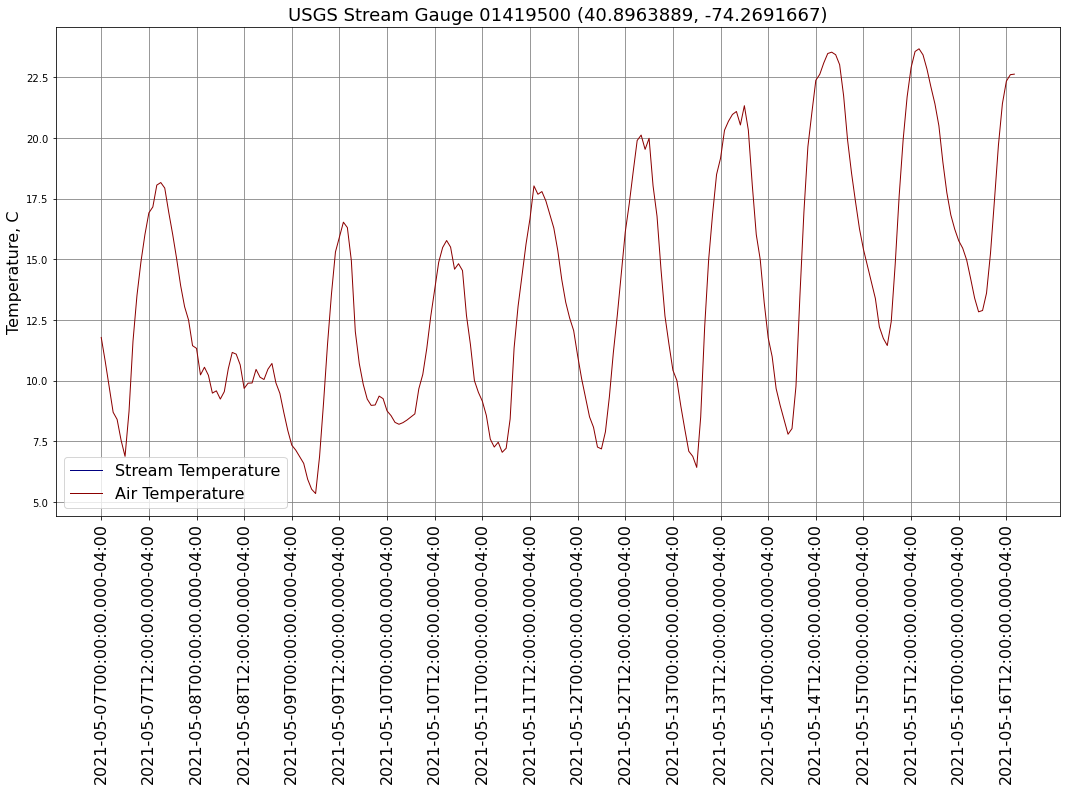

In [40]:
# DISPLAY RESULTS

plt.figure(figsize = (18,9))
plt.plot(list(wt_ts.keys()), list(wt_ts.values()), linewidth=1, color='navy', label="Stream Temperature")
plt.plot(list(at_ts.keys()), list(at_ts.values()), linewidth=1, color='darkred', label="Air Temperature")
#plt.plot(list(wt_ts.keys()), list(wt_ts.values()), linewidth=1, color='navy', label="Stream Temperature")
# PUT FORECASTED TEMPERATURE HERE
plt.grid(color='grey')
plt.legend(loc='lower left', fontsize=16)
plt.xticks(range(0,len(at_ts),12),rotation=90, fontsize=16)
plt.title('USGS Stream Gauge {} ({}, {})'.format(gage, round(y,7), round(x,7)), fontsize=18)
plt.xlabel('',fontsize=16)
plt.ylabel('Temperature, C',fontsize=16)
#plt.savefig('timeseries_temperature.png', bbox_inches='tight')
plt.show()



## FROM HERE SEND ALL DATA TO WT MODEL AND GET FORECAST
{'time': 1619150400,
  'summary': 'Clear',
  'icon': 'clear-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 40.21,
  'apparentTemperature': 37.32,
  'dewPoint': 19.47,
  'humidity': 0.43,
  'pressure': 1014.8,
  'windSpeed': 4.27,
  'windGust': 23.5,
  'windBearing': 276,
  'cloudCover': 0.27,
  'uvIndex': 0,
  'visibility': 10,
  'ozone': 458.3}